# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [22]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import time
import pandas as pd
%matplotlib inline

Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


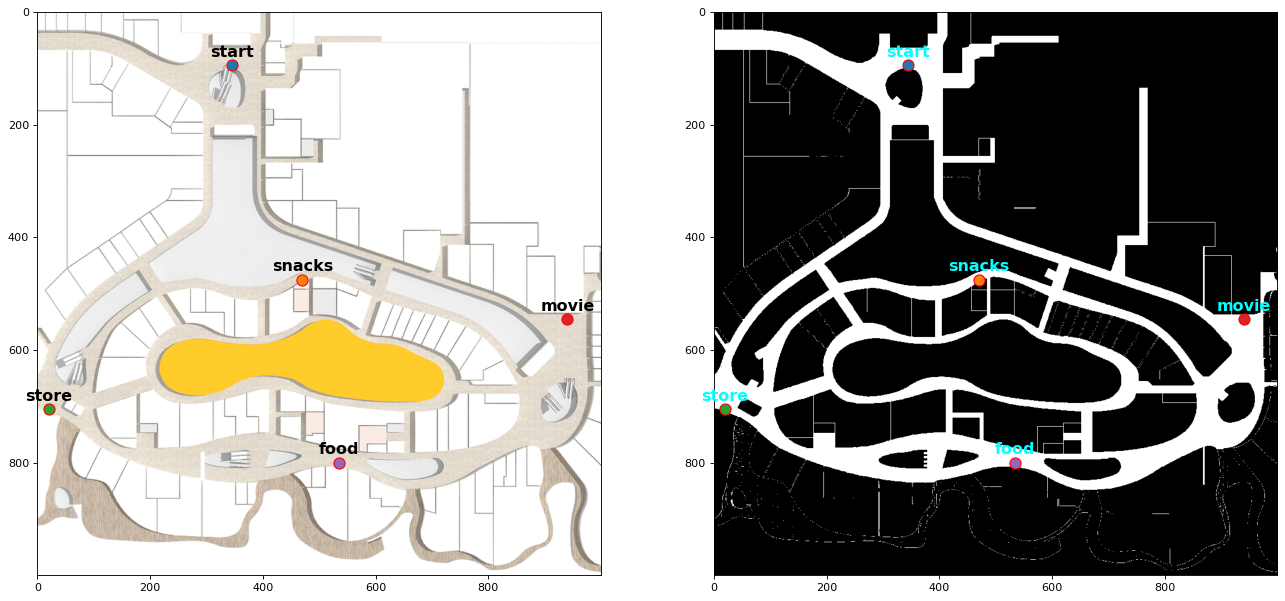

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [3]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

# Task 1
## Set start and end position

In [4]:
# Start and End positions
start_position = tuple(locations['start'])
end_position = tuple(locations['snacks'])

## 1.1 Implement A*

每个格子的尺寸是0.2m;当相邻格子间移动时，移动距离为0.2m;当对角线格子移动时，移动距离为0.282m;因此，如果直接套用普通的A*，结果当然是不对的。当你的路径长度要求大于gridmap中单元格的长度时，你可以考虑以下策略：

1. 路径后处理：首先，你可以按照常规的方式生成路径，然后在路径生成后，对路径进行后处理，合并那些长度小于3的线段。具体来说，你可以遍历路径中的每个线段，如果一个线段的长度小于3，就尝试把它和前一个或后一个线段合并成一个新的线段。但是，需要注意的是，这种方法可能会导致新的线段穿过障碍物，所以在合并线段时，需要检查新的线段是否满足不穿过障碍物的要求。
2. 修改路径规划算法：另一种方法是在路径规划的过程中，就考虑到最小路径长度的要求。具体来说，你可以修改A*算法或者Dijkstra算法，使得它们在扩展节点时，只考虑那些距离当前节点至少3个单位长度的节点。这样，生成的路径就会自然地满足最小路径长度的要求。但是，这种方法可能会增加路径规划的复杂性和计算量。

### 1.1.1 普通Astar 不考虑步长限制

Run Time: 4.439284801483154 seconds
Path length is 690, Distance is: 149.44400000000002


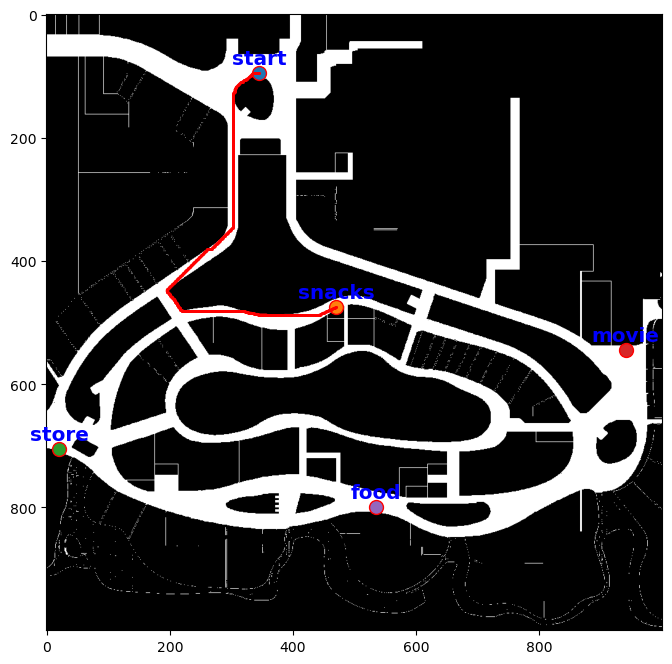

In [14]:
def heuristic_function(start, goal):
    return np.sqrt((start[0] - goal[0]) ** 2 + (start[1] - goal[1]) ** 2) * MAP_RES

# 根据PDF要求指定的cost函数，非对角为0.2，对角为0.282
def get_cost(dx, dy):
    if dx == 0 or dy == 0: 
        return 0.2
    else:
        return 0.282

def reconstruct_path(came_from, current):
    total_path = [current]
    distance = 0
    while current in came_from:
        current = came_from[current]
        distance += get_cost(total_path[-1][0] - current[0], total_path[-1][1] - current[1])
        total_path.append(current)
    return total_path, distance

def visualize_path(path_array, map_img, map_locations):
    plt.figure(figsize=(8, 8))
    plt.imshow(map_img, cmap='gray')
    plot_locations(map_locations, color='blue')
    if path_array:
        x, y = zip(*path_array)
        plt.plot(x, y, marker='o', color='red', markersize=1, linestyle='-')
    plt.show()

def bresenham_line(x1, y1, x2, y2):
    """
    Bresenham's line algorithm
    """
    points = []
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    x, y = x1, y1
    sx = -1 if x1 > x2 else 1
    sy = -1 if y1 > y2 else 1
    if dx > dy:
        err = dx / 2.0
        while x != x2:
            points.append((x, y))
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy / 2.0
        while y != y2:
            points.append((x, y))
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy        
    points.append((x, y))
    return points

def is_line_through_obstacle(point1, point2, gridmap):
    """
    Check if a line goes through an obstacle
    """
    x1, y1 = point1
    x2, y2 = point2
    points = bresenham_line(x1, y1, x2, y2)
    for x, y in points:
        if gridmap[x, y] == 0:  # if the grid is an obstacle
            return True
    return False

def a_star(start_id, goal_id, map_data):
    start = tuple(locations[start_id])
    goal = tuple(locations[goal_id])
    dirs = [(0, 1), (0, -1), (1, 0), (-1, 0), (1,-1), (-1, 1), (1, -1), (-1, -1)]
    open_set = {start}
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic_function(start, goal)}

    while open_set:
        current = min(open_set, key=lambda x: f_score[x])
        if current == goal:
            return reconstruct_path(came_from, goal)

        open_set.remove(current)
        
        for i in range(0,8):
            neighbor = (current[0] + dirs[i][0], current[1] + dirs[i][1])
            # # 严格判定 如果想要进行对角线的移动，还必须检查相邻的两个格子都不是障碍物
            # if 0 <= neighbor[0] < map_data.shape[0] and 0 <= neighbor[1] < map_data.shape[1] :
            #     if map_data[neighbor[0], neighbor[1]] == 0:
            #         continue
            #     if i > 3 and (map_data[neighbor[0], current[1]] == 0 or map_data[current[0],neighbor[1]]==0):
            #         continue
            
            if 0 <= neighbor[0] < map_data.shape[0] and 0 <= neighbor[1] < map_data.shape[1] :
                if map_data[neighbor[0], neighbor[1]] == 0:
                    continue
                if is_line_through_obstacle(current, neighbor, map_data):
                    continue

            cost = get_cost(dirs[i][0], dirs[i][1])
            tentative_g_score = g_score[current] + cost
            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + heuristic_function(neighbor, goal)
                if neighbor not in open_set:
                    open_set.add(neighbor)

    return None

# Finding path from start to store
start_time = time.time()
path, total_distance = a_star('start', 'snacks', grid_map)

print("Run Time:", time.time() - start_time, "seconds")
print("Path steps is " + str(len(path)) + ", Distance is: " + str(total_distance))

visualize_path(path, grid_map_img, locations)

### 考虑步长限制的Astar
路径后处理尝试了，但是失败了，因此考虑直接在路径规划的过程中，加入对最小步长的要求
也就是说，在一个5*5的空间内，机器人可以移动到最外圈的一层（3*3的全部小于步长要求）,总共5+5+3+3 = 16个可选项

Run Time: 8.035780906677246 seconds
Path steps is 317, Distance is: 142.06200000000007


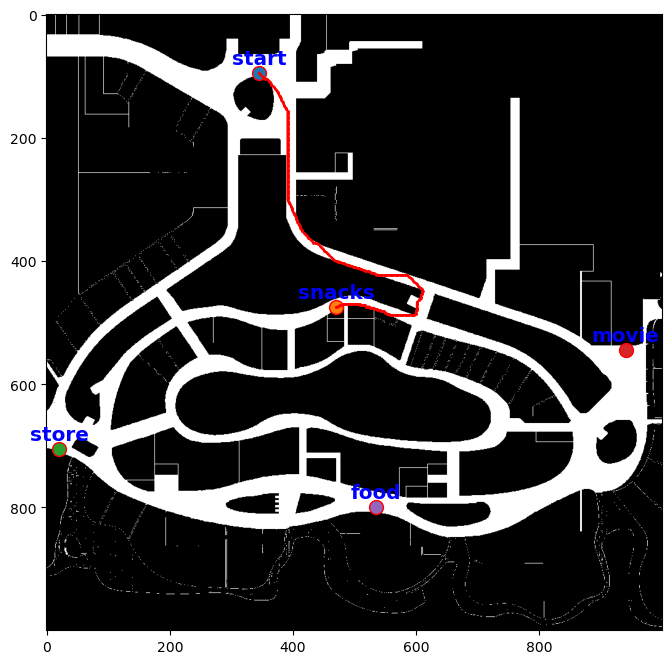

In [16]:
def get_cost_extend(dx, dy):
    if dx == 0 or dy == 0: 
        return 0.4   # 连续两个非对角移动
    elif abs(dx) == 1 or abs(dy) == 1: 
        return 0.482 # 首先对角移动，再非对角移动
    else:
        return 0.564 # 连续两个对角移动

def reconstruct_path_extend(came_from, current):
    total_path = [current]
    distance = 0
    while current in came_from:
        current = came_from[current]
        distance += get_cost_extend(total_path[-1][0] - current[0], total_path[-1][1] - current[1])
        total_path.append(current)
    return total_path, distance
    
def a_star_extend(start_id, goal_id, map_data):
    start = tuple(locations[start_id])
    goal = tuple(locations[goal_id])
    dirs = [(0, 2), (0, -2), (2, 2),(2, 1), (2, 0), (2, -1), (2,-2),(1,2),(1,-2),(0,2),(0,-2),(-1,2),(-1,-2),(-2,2),(-2,1),(-2,0),(-2,-1),(-2,-2)]
    open_set = {start}
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic_function(start, goal)}

    while open_set:
        current = min(open_set, key=lambda x: f_score[x])
        if current == goal:
            return reconstruct_path_extend(came_from, goal)

        open_set.remove(current)
        
        for i in range(0,16):
            neighbor = (current[0] + dirs[i][0], current[1] + dirs[i][1])
            # 严格判定 如果想要进行对角线的移动，还必须检查相邻的两个格子都不是障碍物
            if 0 <= neighbor[0] < map_data.shape[0] and 0 <= neighbor[1] < map_data.shape[1] :
                if map_data[neighbor[0], neighbor[1]] == 0:
                    continue
                if is_line_through_obstacle(current, neighbor, map_data):
                    continue

            cost = get_cost_extend(dirs[i][0], dirs[i][1])
            tentative_g_score = g_score[current] + cost
            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + heuristic_function(neighbor, goal)
                if neighbor not in open_set:
                    open_set.add(neighbor)
                    
start_time = time.time()
path, total_distance = a_star_extend('start', 'snacks', grid_map)

print("Run Time:", time.time() - start_time, "seconds")
print("Path steps is " + str(len(path)) + ", Distance is: " + str(total_distance))

visualize_path(path, grid_map_img, locations)

## 1.2 Implement Dijkstra
可以发现考虑步长的这个方案是可以实施的。

Run Time: 11.990898847579956 seconds
Path steps is 317, Distance is: 142.0620000000002


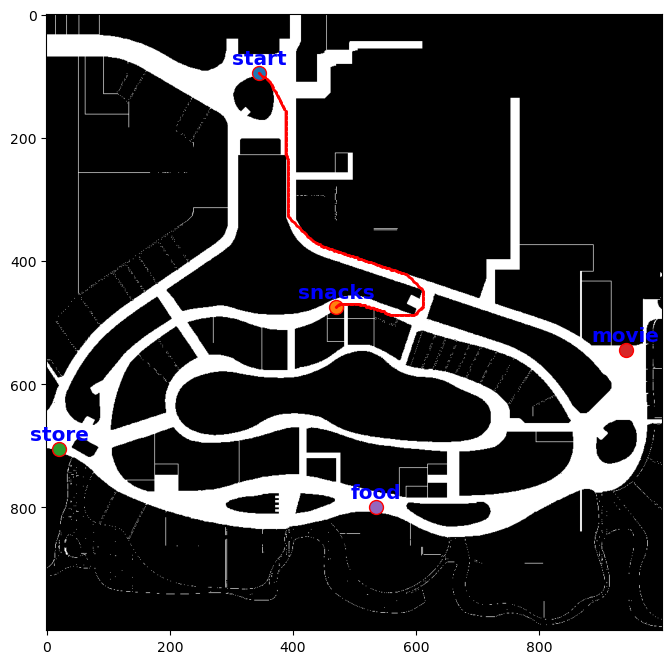

In [17]:
def dijkstra(start_id, goal_id, map_data):
    start = tuple(locations[start_id])
    goal = tuple(locations[goal_id])
    open_set = {start}
    came_from = {}
    g_score = {start: 0}

    while open_set:
        dirs = [(0, 2), (0, -2), (2, 2),(2, 1), (2, 0), (2, -1), (2,-2),(1,2),(1,-2),(0,2),(0,-2),(-1,2),(-1,-2),(-2,2),(-2,1),(-2,0),(-2,-1),(-2,-2)]
        current = min(open_set, key=lambda x: g_score[x])
        if current == goal:
            return reconstruct_path_extend(came_from, current)

        open_set.remove(current)
        
        for i in range(0,16):
            neighbor = (current[0] + dirs[i][0], current[1] + dirs[i][1])
            # 严格判定 如果想要进行对角线的移动，还必须检查相邻的两个格子都不是障碍物
            if 0 <= neighbor[0] < map_data.shape[0] and 0 <= neighbor[1] < map_data.shape[1] :
                if map_data[neighbor[0], neighbor[1]] == 0:
                    continue
                if is_line_through_obstacle(current, neighbor, map_data):
                    continue
                    
                cost = get_cost_extend(dirs[i][0], dirs[i][1])
                tentative_g_score = g_score[current] + cost
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    if neighbor not in open_set:
                        open_set.add(neighbor)

    return None

start_time = time.time()
path, total_distance = dijkstra('start', 'snacks', grid_map)

print("Run Time:", time.time() - start_time, "seconds")
print("Path steps is " + str(len(path)) + ", Distance is: " + str(total_distance))

visualize_path(path, grid_map_img, locations)

## 1.3 Implement Greedy Best First Search

Run Time: 0.9742119312286377 seconds
Path steps is 327, Distance is: 149.178


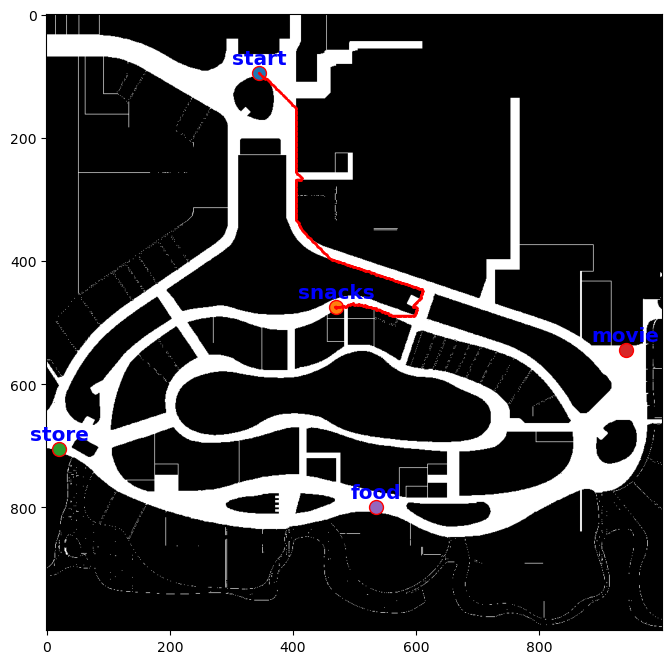

In [19]:
def greedy_best_first_search(start_id, goal_id, map_data):
    start = tuple(locations[start_id])
    goal = tuple(locations[goal_id])
    open_set = {start}
    came_from = {}
    f_score = {start: heuristic_function(start, goal)}

    while open_set:
        dirs = [(0, 2), (0, -2), (2, 2),(2, 1), (2, 0), (2, -1), (2,-2),(1,2),(1,-2),(0,2),(0,-2),(-1,2),(-1,-2),(-2,2),(-2,1),(-2,0),(-2,-1),(-2,-2)]
        current = min(open_set, key=lambda x: f_score[x])
        
        if current == goal:
            return reconstruct_path_extend(came_from, current)

        open_set.remove(current)
        
        for i in range(0,16):
            neighbor = (current[0] + dirs[i][0], current[1] + dirs[i][1])
            # 严格判定 如果想要进行对角线的移动，还必须检查相邻的两个格子都不是障碍物
            if 0 <= neighbor[0] < map_data.shape[0] and 0 <= neighbor[1] < map_data.shape[1] :
                if map_data[neighbor[0], neighbor[1]] == 0:
                    continue
                if is_line_through_obstacle(current, neighbor, map_data):
                    continue
                    
            if neighbor not in f_score:
                came_from[neighbor] = current
                f_score[neighbor] = heuristic_function(neighbor, goal)
                if neighbor not in open_set:
                    open_set.add(neighbor)

    return None

start_time = time.time()
path, total_distance = greedy_best_first_search('start', 'snacks', grid_map)

print("Run Time:", time.time() - start_time, "seconds")
print("Path steps is " + str(len(path)) + ", Distance is: " + str(total_distance))

visualize_path(path, grid_map_img, locations)

## Calculate Distance Matrix
Calculate the distance between each node.

In [23]:
print(locations.keys())
locations_keys = locations.keys()
distance_df = pd.DataFrame(index=locations_keys, columns=locations_keys)

for location1 in locations_keys:
    for location2 in locations_keys:
        if location1 == location2:
            distance_df.loc[location1, location2] = 0
        elif pd.isna(distance_df.loc[location1, location2]):
            start_time = time.time()
            path, total_distance = a_star_extend(location1, location2, grid_map)
            print("Path between " + location1 + " and " + location2 + ", Run Time:", time.time() - start_time, "seconds")
            print("Path steps is " + str(len(path)) + ", Distance is: " + str(total_distance))
            distance_df.loc[location1, location2] = total_distance
            distance_df.loc[location2, location1] = total_distance
            
distance_df

dict_keys(['start', 'snacks', 'store', 'movie', 'food'])
Path between start and snacks, Run Time: 8.084991216659546 seconds
Path steps is 317, Distance is: 142.06200000000007
Path between start and store, Run Time: 7.437427997589111 seconds
Path steps is 330, Distance is: 154.31400000000016
Path between start and movie, Run Time: 6.227823495864868 seconds
Path steps is 393, Distance is: 178.2020000000003
Path between start and food, Run Time: 26.67794156074524 seconds
Path steps is 487, Distance is: 218.9180000000001
Path between snacks and store, Run Time: 3.130704402923584 seconds
Path steps is 249, Distance is: 114.28800000000048
Path between snacks and movie, Run Time: 2.248035192489624 seconds
Path steps is 237, Distance is: 106.53600000000009
Path between snacks and food, Run Time: 5.884645700454712 seconds
Path steps is 284, Distance is: 129.76400000000018
Path between store and movie, Run Time: 26.434699058532715 seconds
Path steps is 482, Distance is: 208.47200000000123
Path b

,start,snacks,store,movie,food
start,0,142.062,154.314,178.202,218.918
snacks,142.062,0,114.288,106.536,129.764
store,154.314,114.288,0,208.472,110.908
movie,178.202,106.536,208.472,0,111.468
food,218.918,129.764,110.908,111.468,0


# Task 2